# Testing notebook

Here we test different implemented algorithms

## Basic Block Matching

In [2]:
from block_matching import disp, disp_inv, disp_rgb, disp_inv_rgb
import block_matching
from skimage import io, color
import matplotlib.pyplot as plt
from mode_filter import mode_filter
import numpy as np
from importlib import reload

reload(block_matching)

<module 'block_matching' from '/Users/pierreadorni/Documents/depth-estimation/noml/block_matching.py'>

In [21]:
Ig = io.imread('teddy/im2.png')
Id = io.imread('teddy/im6.png')

Iggray = color.rgb2gray(Ig)
Idgray = color.rgb2gray(Id)

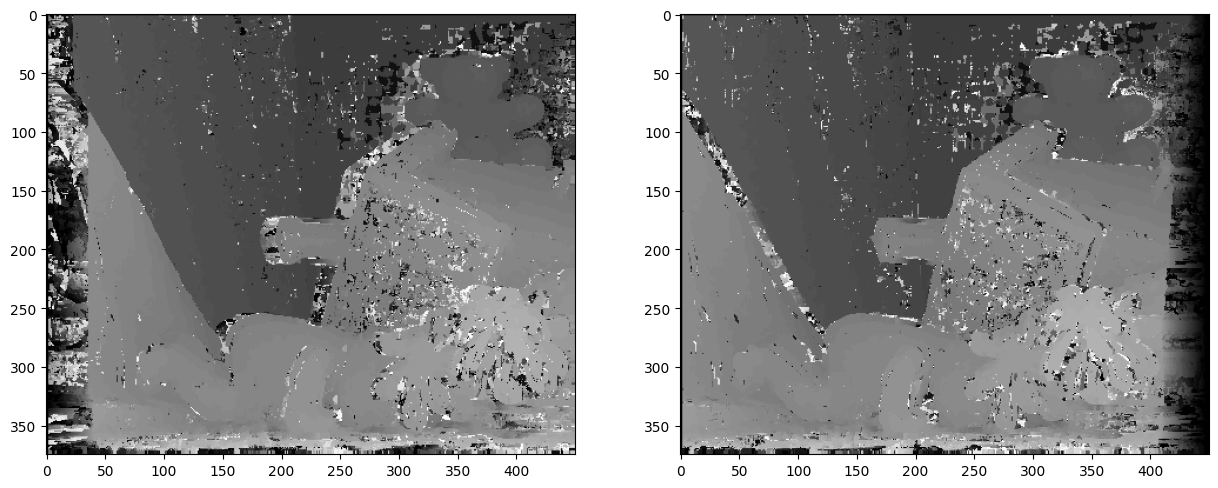

In [53]:
bm_disp_map = disp(Iggray, Idgray, 64)
bm_inv_disp_map = disp_inv(Iggray, Idgray, 64)
fig, ax = plt.subplots(1, 2, figsize=(15, 15))
ax[0].imshow(bm_disp_map, cmap='gray')
ax[1].imshow(bm_inv_disp_map, cmap='gray')

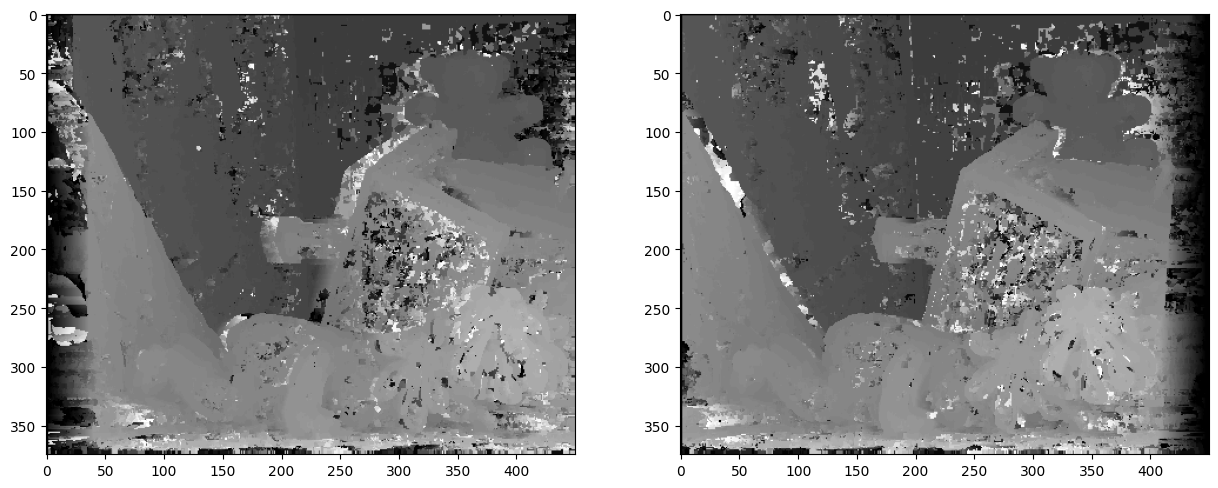

In [52]:
bm_rgb_disp_map = disp_rgb(Ig, Id, 64)
bm_rgb_inv_disp_map = disp_inv_rgb(Ig, Id, 64)
fig, ax = plt.subplots(1, 2, figsize=(15, 15))
ax[0].imshow(bm_rgb_disp_map, cmap='gray')
ax[1].imshow(bm_rgb_inv_disp_map, cmap='gray')

In [54]:
def merge_disps(left: np.ndarray, right: np.ndarray):
    # for each pixel on the left image, go to the right image and back to the left image and check if we are still on the same pixel (approximately)
    # if not, we are on an occluded pixel
    result = left.copy()
    for j in range(left.shape[0]):
        for i in range(left.shape[1]):
            # get the disparity of the pixel
            disp = left[j, i]
            # get the pixel on the right image
            try:
                pixel_right = right[j, i - disp]
                # if the pixel on the right image is not approx. the same as the pixel on the left image, we are on an occluded pixel
                if disp < pixel_right - 10 or disp > pixel_right + 10:
                    result[j, i] = 0
            except IndexError:
                result[j, i] = 0

    return result

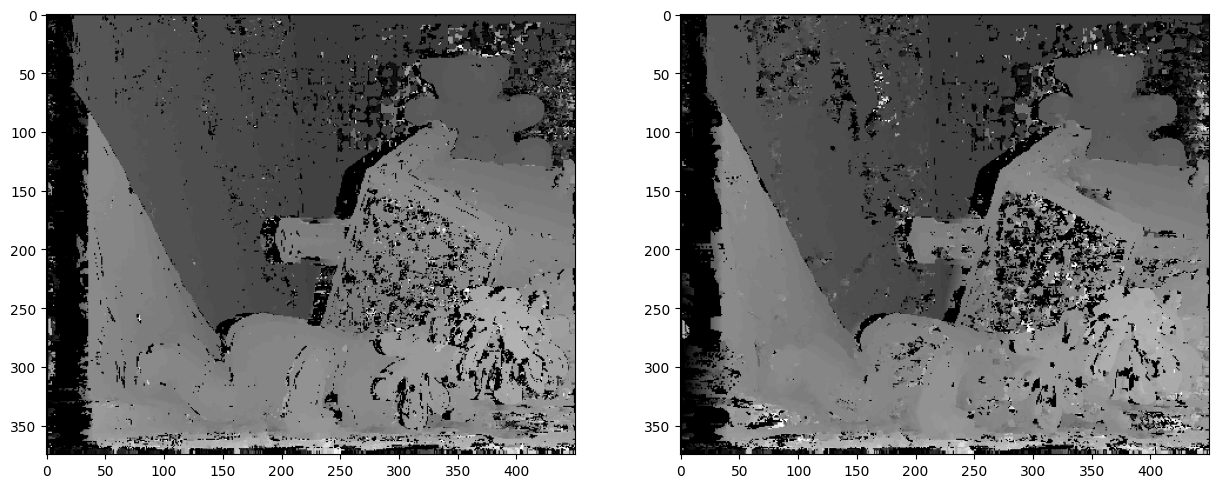

In [55]:
merged_disp_map = merge_disps(bm_disp_map.astype(np.uint16), bm_inv_disp_map.astype(np.uint16))
merged_rgb_disp_map = merge_disps(bm_rgb_disp_map.astype(np.uint16), bm_rgb_inv_disp_map.astype(np.uint16))
fig, ax = plt.subplots(1, 2, figsize=(15, 15))
ax[0].imshow(merged_disp_map, cmap='gray')
ax[1].imshow(merged_rgb_disp_map, cmap='gray')

In [56]:
def mode_filter_occl(disp_map: np.ndarray, filter_size=5):
    """
    Apply a mode filter to the disparity map
    :param disp_map: disparity map
    :param filter_size: size of the filter, defaults to 5
    :return: filtered disparity map
    """
    disp_map_filtered = np.zeros_like(disp_map)
    for j in range(disp_map.shape[0] - filter_size):
        for i in range(disp_map.shape[1] - filter_size):
            # get the values in the filter
            values = disp_map[j:j + filter_size, i:i + filter_size]
            # compute the mode except 0
            mode = np.bincount(values.flatten().astype(int)).argmax()
            if mode == 0:
                try:
                    mode = np.bincount(values.flatten().astype(int))[1:].argmax() + 1
                except ValueError:
                    mode = 0
            # assign the mode to the center of the filter
            disp_map_filtered[j + filter_size // 2, i + filter_size // 2] = mode
    return disp_map_filtered

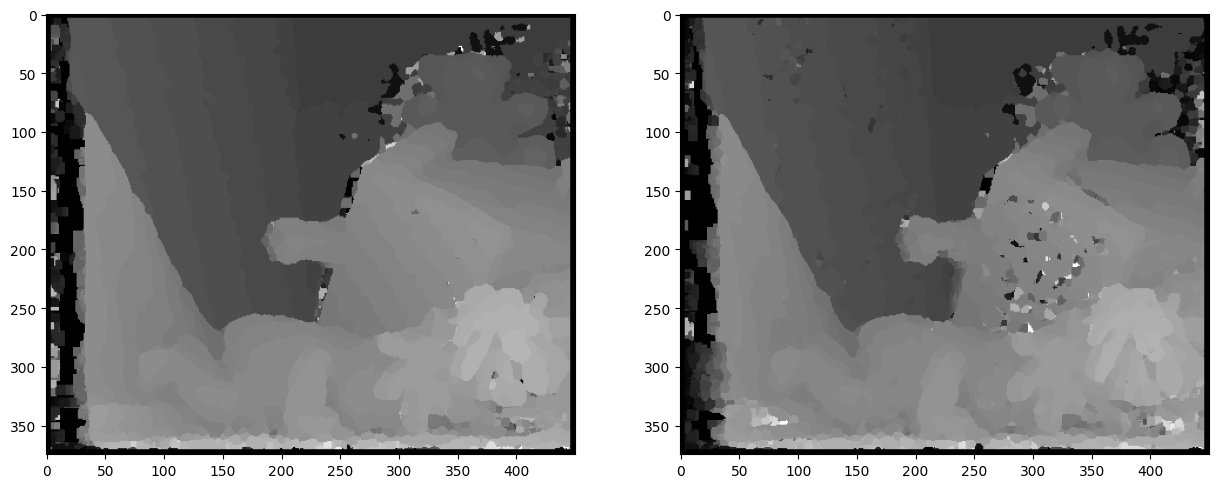

In [58]:
merged_disp_map_filtered = mode_filter_occl(merged_disp_map, 8)
merged_rgb_disp_map_filtered = mode_filter_occl(merged_rgb_disp_map, 8)
fig, ax = plt.subplots(1, 2, figsize=(15, 15))
ax[0].imshow(merged_disp_map_filtered, cmap='gray')
ax[1].imshow(merged_rgb_disp_map_filtered, cmap='gray')

## Weighted window

### Yoon Kweon implementation

In [27]:
from yoon_kweon import yoon_kweon_diss, our_diss
import yoon_kweon
reload(yoon_kweon)

<module 'yoon_kweon' from '/Users/pierreadorni/Documents/depth-estimation/noml/yoon_kweon.py'>

In [28]:
i_ref_lab = color.rgb2lab(Ig)
i_tgt_lab = color.rgb2lab(Id)

yk_disp_map = yoon_kweon_diss(Ig, Id, i_ref_lab, i_tgt_lab, block_size=3)

100%|██████████| 375/375 [00:25<00:00, 14.75it/s]


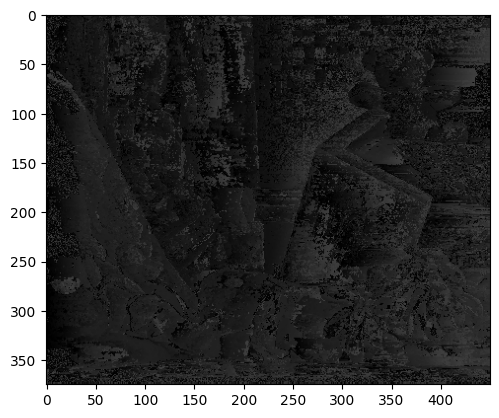

In [30]:
plt.imshow(yk_disp_map, cmap='gray')

Looking at the results, the implementation is bugged. We need to investigate it.

### Our implementation

In [31]:
from yoon_kweon import our_diss
import yoon_kweon
reload(yoon_kweon)

<module 'yoon_kweon' from '/Users/pierreadorni/Documents/depth-estimation/noml/yoon_kweon.py'>

100%|██████████| 375/375 [02:54<00:00,  2.15it/s]


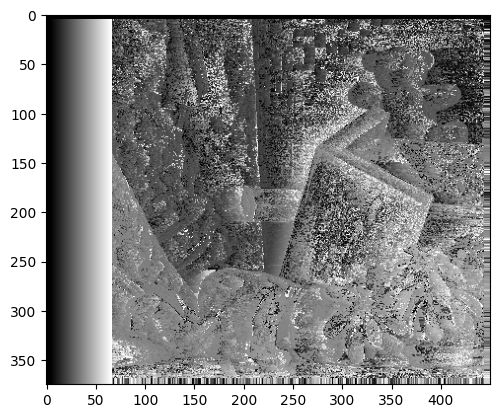

In [32]:
aw_disp_map = our_diss(Ig, Id, i_ref_lab, i_tgt_lab, block_size=11)
plt.imshow(aw_disp_map, cmap='gray')

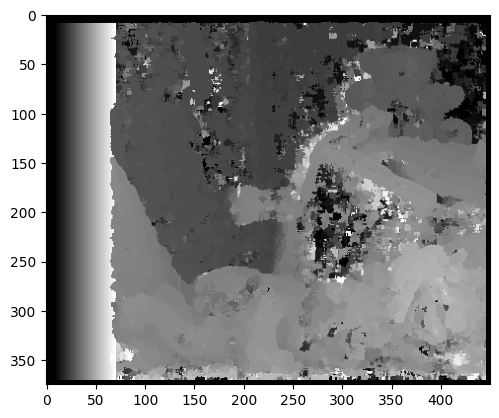

In [37]:
# apply mode filter
aw_disp_map_filtered = mode_filter(aw_disp_map, 8)
plt.imshow(aw_disp_map_filtered, cmap='gray')

C'est vraiment très très mauvais hein

In [24]:
occl_gt = io.imread('teddy/occl.png')
occl_gt.shape

(375, 450)

In [23]:
io.imsave('teddy/occl.png', occl_gt[:,:,0].astype(np.uint8))